<a href="https://colab.research.google.com/github/mostafaahmed-12/automatic-question-tagging-system/blob/main/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup
from nltk.tokenize import ToktokTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout,Conv2D,MaxPooling2D,Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
# from skmultilearn.model_selection import iterative_train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
questions = pd.read_csv("/content/drive/MyDrive/nlp_datat/x.csv", encoding="ISO-8859-1")
tags_output = pd.read_csv("/content/drive/MyDrive/nlp_datat/y.csv", encoding="ISO-8859-1")

In [5]:
tags_output['Tag'] = tags_output['Tag'].astype(str)

In [6]:
print("Questions:" + str(questions.shape))
print("tags_output:" + str(tags_output.shape))

Questions:(100000, 7)
tags_output:(100000, 2)


In [7]:
tags_fre = tags_output['Tag'].value_counts().to_frame()
tags_fre.columns = ['Tag frequency']
tags_fre['Tag'] = tags_fre.index


In [8]:
most_tags = tags_fre[:50]
most_tags

,Tag frequency,Tag
c#,4657,c#
.net,2628,.net
java,2436,java
asp.net,2143,asp.net
php,1884,php
javascript,1799,javascript
c++,1686,c++
python,1329,python
jquery,1249,jquery
sql,1234,sql


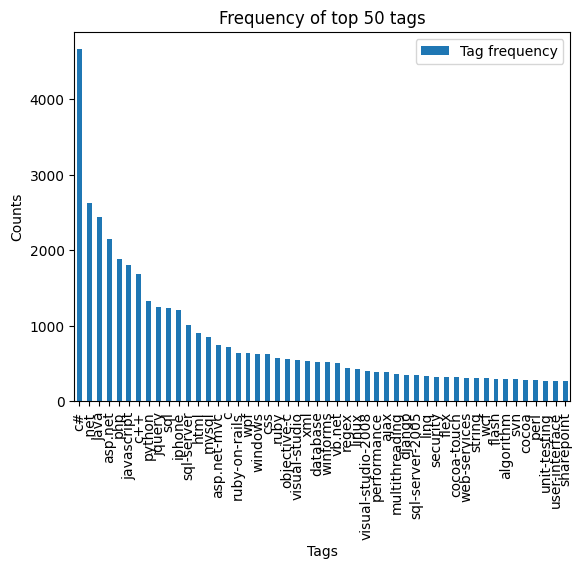

In [9]:
i=np.arange(50)
most_tags.head(50).plot(kind='bar')
plt.title('Frequency of top 50 tags')
plt.xticks(i, most_tags['Tag'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [10]:
merge_tags=pd.merge(tags_output,tags_fre,on='Tag',how='left')
merge_tags=merge_tags[merge_tags['Tag frequency']>=271]
merge_tags

,Id,Tag,Tag frequency
0,80,flex,329
3,90,svn,291
7,120,sql,1234
8,120,asp.net,2143
10,180,algorithm,300
...,...,...,...
99985,1750010,c#,4657
99989,1750040,php,1884
99990,1750040,mysql,847
99993,1750070,c#,4657


In [11]:
grouped_tags = merge_tags.groupby('Id')['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags = grouped_tags.reset_index()
grouped_tags

,Id,Tag
0,80,flex
1,90,svn
2,120,sql asp.net
3,180,algorithm
4,260,c# .net
...,...,...
27387,1749930,asp.net
27388,1750010,c#
27389,1750040,php mysql
27390,1750070,c#


In [12]:
questions[questions["Id"]==120]

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...


In [13]:
tags_output[tags_output["Id"]==120]

,Id,Tag
7,120,sql
8,120,asp.net
9,120,sitemap


In [14]:
grouped_tags[grouped_tags['Id']==120]

,Id,Tag
2,120,sql asp.net


In [15]:
questions_tags =pd.merge(questions, grouped_tags,on='Id')
questions_tags["Tag"].apply(lambda x:x.lower())
questions_tags.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net


In [16]:
questions_tags.drop_duplicates(inplace=True)

In [17]:
questions_tags["tag_count"] =questions_tags["Tag"].apply(lambda x:len(x.split()))

In [18]:
questions_tags["Tag"] =questions_tags["Tag"].apply(lambda x:x.split(' '))

In [19]:
questions_tags.head(4)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag,tag_count
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,[flex],1
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn],1
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]",2
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm],1


In [20]:
print("maximum number of tags for each question "+str(questions_tags["tag_count"].max()))
print("minimum number of tags for each question "+str(questions_tags["tag_count"].min()))
print("mean number of tags for each question "+str(math.floor(questions_tags["tag_count"].mean())))

maximum number of tags for each question 5
minimum number of tags for each question 1
mean number of tags for each question 1


In [21]:
questions_tags.shape

(27392, 9)

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer
m=MultiLabelBinarizer()
labels=m.fit_transform(questions_tags['Tag'])

In [23]:
labels
print(len(labels[0]))

50


In [24]:
tags=m.classes_
tags

array(['.net', 'ajax', 'algorithm', 'asp.net', 'asp.net-mvc', 'c', 'c#',
       'c++', 'cocoa', 'cocoa-touch', 'css', 'database', 'django',
       'flash', 'flex', 'html', 'iphone', 'java', 'javascript', 'jquery',
       'linq', 'linux', 'multithreading', 'mysql', 'objective-c',
       'performance', 'perl', 'php', 'python', 'regex', 'ruby',
       'ruby-on-rails', 'security', 'sharepoint', 'sql', 'sql-server',
       'sql-server-2005', 'string', 'svn', 'unit-testing',
       'user-interface', 'vb.net', 'visual-studio', 'visual-studio-2008',
       'wcf', 'web-services', 'windows', 'winforms', 'wpf', 'xml'],
      dtype=object)

In [25]:
tok_tokenizer = ToktokTokenizer()
lemmatizer = WordNetLemmatizer()

In [26]:
stop_words=set(stopwords.words('english'))

In [27]:
def token_remove_stop_words_punc_lemma(text):
    text = text.lower()
    tokenized_text = tok_tokenizer.tokenize(text)
    new_text = []
    for word in tokenized_text:
        if word in m.classes_:
            new_text.append(word)
        elif word not in stop_words and word not in string.punctuation:
            if word.isdigit() == False:
                new_text.append(word)

    pos_tags = nltk.pos_tag(new_text)

    lemmatized_tokens = []
    for token, pos in pos_tags:
        if pos.startswith('V'):  # verb
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
        elif pos.startswith('R'):
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='r'))
        elif pos.startswith('S'):
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='s'))
        elif pos.startswith('A'):
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='a'))
        elif pos.startswith('N'):
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
        else:
            lemmatized_tokens.append(token)

    text = ' '.join(map(str, lemmatized_tokens))

    return text


In [28]:

def remove_html_tags(text):
    text = BeautifulSoup(text, features="html.parser").get_text().strip()
    return text


In [29]:
questions_tags['clean_body'] = questions_tags["Body"].apply(lambda x: remove_html_tags(x))
questions_tags['clean_body'] = questions_tags["clean_body"].apply(lambda x: token_remove_stop_words_punc_lemma(x))
questions_tags['clean_title'] = questions_tags["Title"].apply(lambda x: token_remove_stop_words_punc_lemma(x))


In [30]:
questions_tags['clean_title'].head()

0    sqlstatement.execute( multiple query one state...
1            good branching merge tutorial tortoisesvn
2                                     asp.net site map
3                          function create color wheel
4            add script functionality .net application
Name: clean_title, dtype: object

In [31]:
questions_tags['clean_body'].head()

0    write database generation script sql want exec...
1    really good tutorial explain branch merge apac...
2    anyone get experience create sql-based asp.net...
3    something pseudo-solved many time never quite ...
4    little game write c#. us database back-end. tr...
Name: clean_body, dtype: object

In [32]:
questions_tags['Tag'].head()

0            [flex]
1             [svn]
2    [sql, asp.net]
3       [algorithm]
4        [c#, .net]
Name: Tag, dtype: object

In [33]:
questions_tags['Combined_text'] = questions_tags['clean_title'] + ' ' + questions_tags['clean_body']

In [34]:
X1 = questions_tags['clean_body']
X2 = questions_tags['clean_title']
X3 = questions_tags['Combined_text']

In [35]:
y=labels
print(y[0])
print(len(y[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
50


In [36]:
tidf_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       ngram_range=(1,3),
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)


In [37]:
X1_tfidf = tidf_X1.fit_transform(X1)

In [38]:


x=X1_tfidf
y=labels
x_train, x_test, y_train, y_test =train_test_split(x,y, test_size=0.2, random_state=42)

print(x_train.shape)
print( x_test.shape)
print( y_train.shape)
print( y_test.shape)

(21913, 1000)
(5479, 1000)
(21913, 50)
(5479, 50)


In [39]:

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print('F1 Score: {}'.format(f1_score(y_test, y_pred, average='micro')))



In [40]:
C=[1,2,3,4,5,6,7,8,9,10]
for i in C:
  svm_model = LinearSVC(C=i)
  clf = OneVsRestClassifier(svm_model)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print_score(y_pred, clf)
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy Score: {}'.format(accuracy))
  print('----')


Clf:  OneVsRestClassifier
F1 Score: 0.511294490289239
Accuracy Score: 0.27888300784814746
----
Clf:  OneVsRestClassifier
F1 Score: 0.5156300879192445
Accuracy Score: 0.27997809819310093
----
Clf:  OneVsRestClassifier
F1 Score: 0.5154523618895116
Accuracy Score: 0.2772403723307173
----
Clf:  OneVsRestClassifier
F1 Score: 0.5145746109487321
Accuracy Score: 0.27505019164081035
----
Clf:  OneVsRestClassifier
F1 Score: 0.5125195618153364
Accuracy Score: 0.27395510129585693
----
Clf:  OneVsRestClassifier
F1 Score: 0.5089188769970528
Accuracy Score: 0.2697572549735353
----
Clf:  OneVsRestClassifier
F1 Score: 0.5073043210825773
Accuracy Score: 0.26902719474356634
----
Clf:  OneVsRestClassifier
F1 Score: 0.5055415424596804
Accuracy Score: 0.26738455922613613
----
Clf:  OneVsRestClassifier
F1 Score: 0.5043385599025727
Accuracy Score: 0.265011863478737
----
Clf:  OneVsRestClassifier
F1 Score: 0.5029168876430032
Accuracy Score: 0.2646468333637525
----


In [41]:
from sklearn.metrics import confusion_matrix


In [42]:
sgd = SGDClassifier(n_jobs=-1)
lr = LogisticRegression()
svm_model = LinearSVC(C=2)
non_linear=SVC(kernel='rbf', C=1.0)
dt = DecisionTreeClassifier(max_depth=5,min_samples_leaf=2, min_samples_split=2)





Clf:  SGDClassifier
F1 Score: 0.45805928462023604
Accuracy Score: 0.24603029749954372
----
Clf:  LogisticRegression
F1 Score: 0.43906842390323164
Accuracy Score: 0.22577112611790473
----
Clf:  LinearSVC
F1 Score: 0.5156300879192445
Accuracy Score: 0.27997809819310093
----
Clf:  DecisionTreeClassifier
F1 Score: 0.5194290245836637
Accuracy Score: 0.26993977003102754
----


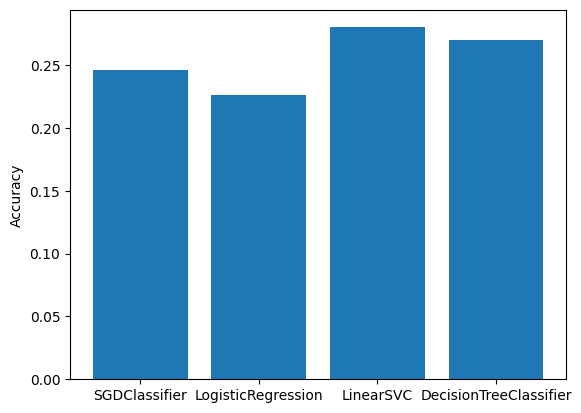

In [43]:
import matplotlib.pyplot as plt
accuracy_scores = []

for classifier in [sgd, lr, svm_model,dt]:
  clf = OneVsRestClassifier(classifier)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy)
  print_score(y_pred, classifier)
  print('Accuracy Score: {}'.format(accuracy))
  print('----')


classifier_names = ['SGDClassifier', 'LogisticRegression', 'LinearSVC', 'DecisionTreeClassifier']
x_ticks = np.arange(len(classifier_names))
plt.bar(x_ticks, accuracy_scores)
plt.xticks(x_ticks, classifier_names)
plt.ylabel('Accuracy')
plt.show()

In [44]:
x = 'how to write ml code in python and c#'
x=[token_remove_stop_words_punc_lemma(x)]
print(x)
xt = tidf_X1.transform(x)
s = clf.predict(xt)


['write ml code python c#']


In [45]:
m.inverse_transform(s)

[('c#', 'python')]

In [46]:
x_train=x_train.toarray()
x_test=x_test.toarray()

In [47]:
model = Sequential()
model.add(Dense(512, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

hist=model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
685/685 [==============================] - 12s 15ms/step - loss: 0.1300 - accuracy: 0.1547 - val_loss: 0.0884 - val_accuracy: 0.3161
Epoch 2/50
685/685 [==============================] - 10s 15ms/step - loss: 0.0888 - accuracy: 0.3526 - val_loss: 0.0734 - val_accuracy: 0.4223
Epoch 3/50
685/685 [==============================] - 8s 12ms/step - loss: 0.0775 - accuracy: 0.4219 - val_loss: 0.0705 - val_accuracy: 0.4594
Epoch 4/50
685/685 [==============================] - 10s 14ms/step - loss: 0.0718 - accuracy: 0.4571 - val_loss: 0.0693 - val_accuracy: 0.4722
Epoch 5/50
685/685 [==============================] - 10s 15ms/step - loss: 0.0668 - accuracy: 0.4862 - val_loss: 0.0685 - val_accuracy: 0.4661
Epoch 6/50
685/685 [==============================] - 9s 12ms/step - loss: 0.0628 - accuracy: 0.5110 - val_loss: 0.0685 - val_accuracy: 0.4744
Epoch 7/50
685/685 [==============================] - 11s 16ms/step - loss: 0.0591 - accuracy: 0.5342 - val_loss: 0.0684 - val_accuracy: 0

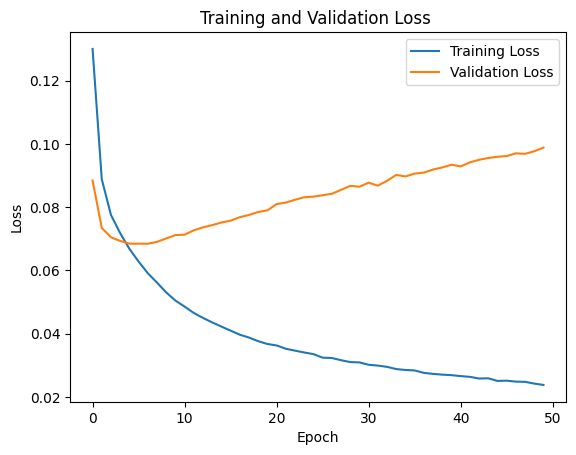

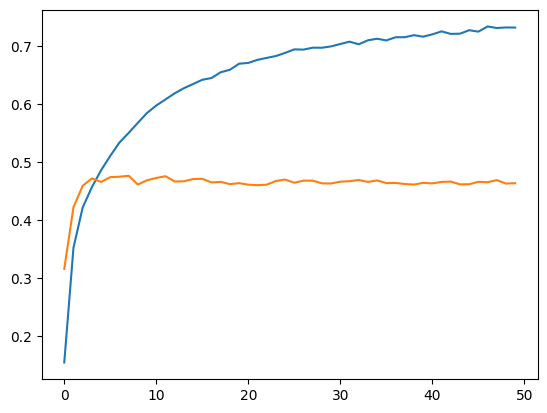

In [48]:
history=hist
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.show()
